<a href="https://colab.research.google.com/github/peluca13/LDM_Cuadernos/blob/main/LDM_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación de entorno

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%tensorflow_version 2.7.0
!sudo pip3 install keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard      #Observar funcionamiento del modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator   #Generar imagenes extra
import matplotlib.pyplot as plt
import pathlib

# Carga de datos

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [12]:
PATH='/content/drive/MyDrive/DataSet'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [13]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 434 files belonging to 2 classes.
Using 348 files for training.


In [14]:
class_names = train_dataset.class_names
class_names

['noPitanga', 'pitanga']

In [15]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 434 files belonging to 2 classes.
Using 86 files for validation.


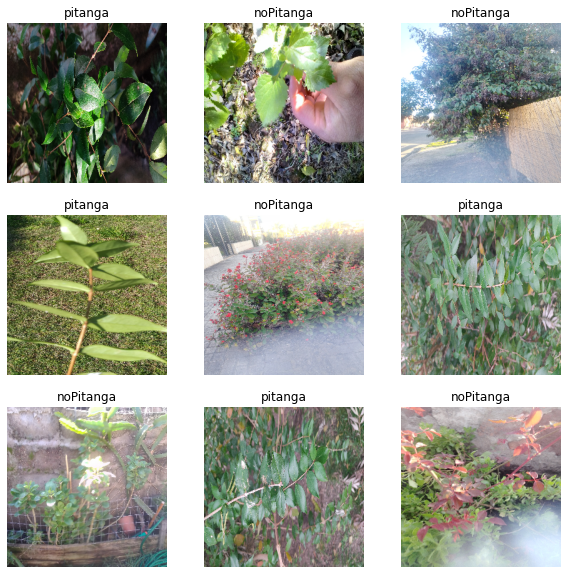

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 46 files belonging to 2 classes.


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Preprocesado



Aumento de datos (Volteo horizontal, rotación, Acercamiento)

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

Muestra de datos "aumentados"

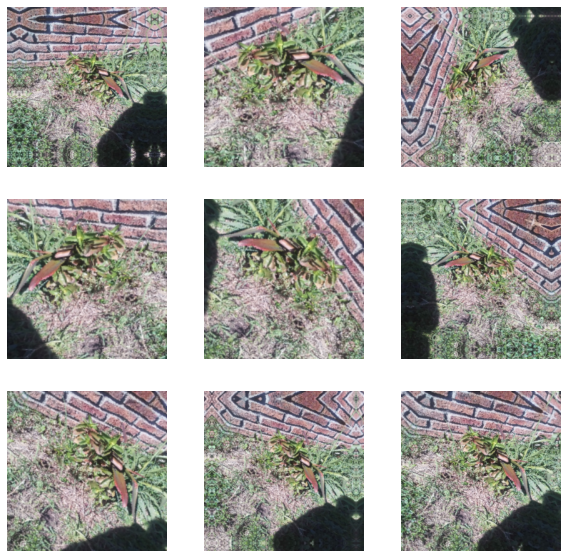

In [13]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Reescalado

In [14]:
rescale = preprocessing.Rescaling(1./255)

# Generacion del modelo


Transferencia de modelo pre entrenado Inception V3

In [37]:
base_model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [38]:
base_model_inception_v3.trainable = False

In [39]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_inception_v3(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_v3 = tf.keras.Model(inputs, outputs, name='inception_v3')

In [40]:
model_inception_v3.summary()

Model: "inception_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)            

In [41]:
model_inception_v3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)

In [43]:
history_inception_v3 = model_inception_v3.fit(train_dataset,
                            epochs=10,
                            validation_data=validation_dataset,
                            callbacks=[callback])

Epoch 1/10
11/11 [==============================] - 25s 871ms/step - loss: 1.5040 - accuracy: 0.5489 - val_loss: 0.6486 - val_accuracy: 0.6395
Epoch 2/10
11/11 [==============================] - 20s 762ms/step - loss: 0.3981 - accuracy: 0.8247 - val_loss: 0.3200 - val_accuracy: 0.8605
Epoch 3/10
11/11 [==============================] - 20s 756ms/step - loss: 0.3152 - accuracy: 0.8649 - val_loss: 0.2595 - val_accuracy: 0.8953
Epoch 4/10
11/11 [==============================] - 20s 761ms/step - loss: 0.2056 - accuracy: 0.8966 - val_loss: 0.2095 - val_accuracy: 0.9186
Epoch 5/10
11/11 [==============================] - 20s 760ms/step - loss: 0.1992 - accuracy: 0.9052 - val_loss: 0.1933 - val_accuracy: 0.9419
Epoch 6/10
11/11 [==============================] - 20s 760ms/step - loss: 0.1987 - accuracy: 0.9253 - val_loss: 0.2348 - val_accuracy: 0.9186
Epoch 7/10
11/11 [==============================] - 20s 766ms/step - loss: 0.1874 - accuracy: 0.9339 - val_loss: 0.1742 - val_accuracy: 0.9419

In [44]:
model_inception_v3.evaluate(test_dataset)

2/2 [==============================] - 2s 92ms/step - loss: 0.2602 - accuracy: 0.8913


[0.26016393303871155, 0.8913043737411499]

In [45]:
model_inception_v3.save('/content/drive/MyDrive/Modelos/DataSet/InceptionV3/model_inception_v3.h5')
#model_inception_v3.save_weights('/content/drive/MyDrive/Modelos/DataSet/InceptionV3/model_inception_v3_pesos.h5')


# Métricas


Gráficas Entrenamineto/Validación

In [46]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

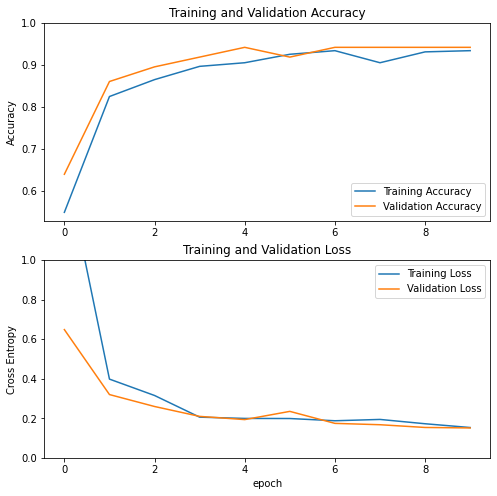

In [47]:
plotLearningCurve(history_inception_v3)

Matriz de Confusión

Found 46 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667        23
           1     0.0000    0.0000    0.0000        23

    accuracy                         0.5000        46
   macro avg     0.2500    0.5000    0.3333        46
weighted avg     0.2500    0.5000    0.3333        46



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


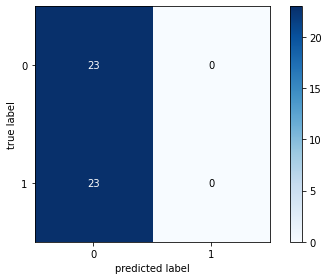

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

width_shape = 256
height_shape = 256
batch_size = 32 

#class_names = ['PITANGA','NO PITANGA']

test_datagen = ImageDataGenerator()


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False,)

custom_Model= load_model('/content/drive/MyDrive/Modelos/DataSet/InceptionV3/model_inception_v3.h5')

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)

y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc,
                                colorbar=True,
                                show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

# Prueba logits

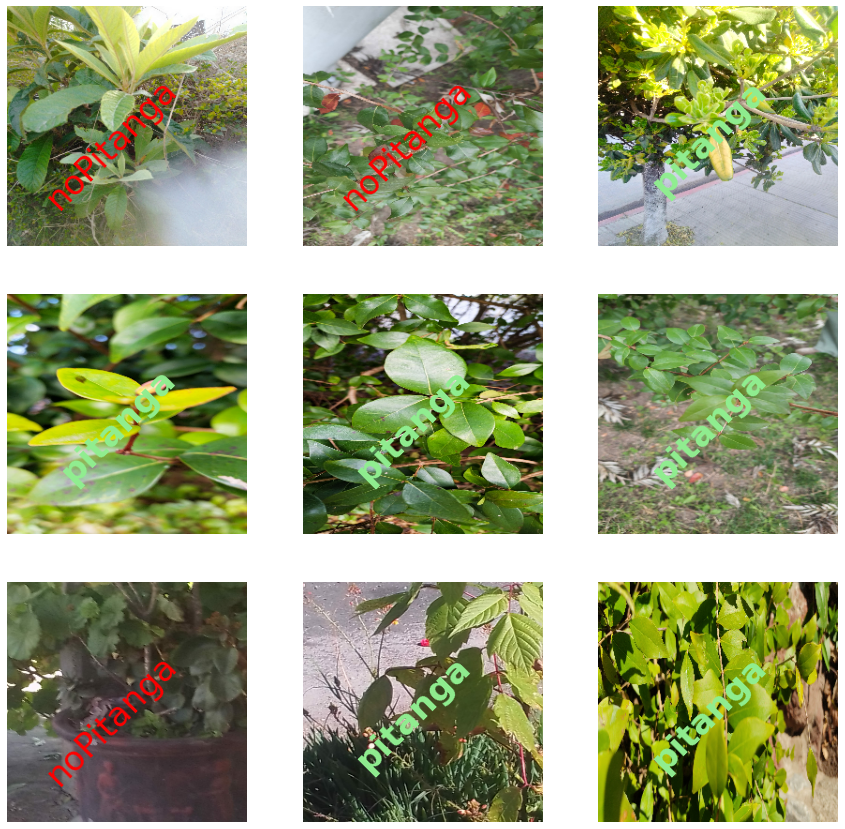

In [20]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow import keras
from datetime import datetime
import itertools
import io


modelI = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/DataSet/InceptionV3/model_inception_v3.h5')
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = modelI.predict_on_batch(image_batch).flatten()

# Aplicar sigmoid ya que nuestro modelo devuelve logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='pitanga':
        plt.text(50, 200, label, rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")

Found 46 files belonging to 2 classes.
